In [1]:
import os, sys
import pandas as pd
import numpy as np
import matminer as mm
import pymatgen as pym
from scipy import stats
import requests
from pprint import pprint
from copy import deepcopy
import joblib
from itertools import combinations
from PIL import Image
import itertools
import traceback
import re

import sklearn as sk
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn import linear_model

from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition

from pymatgen.core.periodic_table import Element

import shap

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cycler
prop_cycle = plt.rcParams['axes.prop_cycle']
DEFAULT_COLORS = prop_cycle.by_key()['color']
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
plt.rc('text', usetex=True)
plt.rc('font', **{'size':8})
DEFCOLS = prop_cycle.by_key()['color']

# 0. Some pre-tabulated data

In [2]:
##########################################################################
# Get All H2 storage materials in MP
##########################################################################
#https://www.materialsproject.org/#search/materials/{%22nelements%22%3A{%22%24gt%22%3A1}%2C%22notelements%22%3A[%22C%22%2C%22N%22%2C%22O%22%2C%22F%22%2C%22Cl%22%2C%22S%22%2C%22P%22]%2C%22elements%22%3A%22H%22}

In [3]:
##########################################################################
# Get M-H bond energies from Sanliang's OQMD table
##########################################################################
elem_Ef = pd.read_csv('ml_data/ElementalH_Ef.csv')

In [4]:
##########################################################################
# Get MP MH formation energies
##########################################################################
MAPIKEY = open("MY_MP_API.txt","r").readlines()[0].strip()
if not os.path.exists('ml_data/ElementalH_Ef_MP.csv'):
    elem_Ef_MP = deepcopy(elem_Ef)
    Ef_MP = []
    for spec in elem_Ef['Species']:
        if type(spec) == str:
            # missing values stored as <class 'float'> nan
            print(type(spec),spec)
            r = requests.get("https://www.materialsproject.org/rest/v2/materials/"+\
                             "H-%s/vasp?API_KEY=%s"%(spec,MAPIKEY),verify=False)
            allEfperAtom = [dat['formation_energy_per_atom'] for dat in r.json()['response']]
            if len(allEfperAtom) !=0:
                Ef_MP.append(min(allEfperAtom))
            else:
                Ef_MP.append('')
        else:
            Ef_MP.append(spec)
    elem_Ef_MP['Ef']=Ef_MP
    elem_Ef_MP.to_csv('ml_data/ElementalH_Ef_MP.csv')
else:
    elem_Ef_MP = pd.read_csv('ml_data/ElementalH_Ef_MP.csv')

# 1. Some helper functions

In [5]:
def sk_linear_model(X,y):
    inds = np.argsort(X,axis=0).squeeze()
    fit = linear_model.LinearRegression().fit(X,y)
    pred = fit.predict(X)
    r2 = r2_score(pred,y)
    return fit, r2, pred, inds

def draw_y_equals_x(ax):

    xlim=ax.get_xlim()
    ylim=ax.get_ylim()

    ax.plot([max(xlim[0],ylim[0]), min(xlim[1],ylim[1])],
            [max(xlim[0],ylim[0]), min(xlim[1],ylim[1])],
            linestyle='--',
            c='black',
            linewidth=1)
    
def draw_y_equals_x_v2(ax):

    xlim=ax.get_xlim()
    ylim=ax.get_ylim()

    ax.plot([min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
            [min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
            linestyle='--',
            c='black',
            linewidth=1)
    
    
def vertical_img_concat(flist,savename):
    images = [Image.open(x) for x in flist]
    widths, heights = zip(*(i.size for i in images))
    print(widths,heights)
    
    total_height = sum(heights)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for im in images:
      new_im.paste(im, (0, y_offset))
      y_offset += im.size[1]

    if savename is not None:
        new_im.save(savename)

def horizontal_img_concat(flist,savename):
    
    images = [Image.open(x) for x in flist]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
      new_im.paste(im, (x_offset,0))
      x_offset += im.size[0]

    if savename is not None:
        new_im.save(savename)
        
    
def plot_special_marker_fcn(ax, thiscomplist, descr, lnPeqos, descr2, edgecolor="black",
            marker="*",s=100,c="red",linewidths=0.5):
    """
    To plot a specific composition as its own marker
    """

    thiscompset = set(thiscomplist)
    thiscompstr = "".join(sorted(thiscomplist, key=lambda x: Element(x).Z))
    thiscompstr = r"$\textrm{"+thiscompstr+"}$"
    thiscompind = setcombinations.index(thiscompset)
    ax.scatter(descr[thiscompind],lnPeqos[thiscompind],edgecolor=edgecolor,
               marker=marker,s=s, c=c,label=thiscompstr,linewidths=linewidths)

    print("%s , %s , %.1f , %.2f , %.1f"%(thiscomplist,allweights[thiscompind],
                                        descr[thiscompind],
                                        descr2[thiscompind],
                                        lnPeqos[thiscompind]))
def column_to_label(colname):

    if colname == 'Heat_of_Formation_kJperMolH2':
        return r"$\Delta H$ [kJ/mol H$_2$]"
    elif colname == 'Entropy_of_Formation_kJperMolH2perK':
        return r"$\Delta S$ [J/(mol H$_2$ $\cdot$ K)]"
    elif colname == 'Equilibrium_Pressure_25C':
        return r"$P_{eq}^o$"
    elif colname == 'LnEquilibrium_Pressure_25C':
        return r"$\ln (P_{eq}^o/P_o)$"
    elif colname == 'volume':
        return r"$V_{cell}$ [\AA$^3$]"
    elif colname == 'volume_ps':
        return r"$\nu_{pa}^{MP}$ [\AA$^3$/atom]"
    elif colname == 'volume_ps_generic':
        return r"$\bar{\nu_{pa}}$ [\AA$^3$/atom]"
    elif colname == 'mean_GSvolume_pa':
        return r"$\nu_{pa}^{Magpie}$ [\AA$^3$/atom]"
    elif colname == 'empty_volume_ps':
        return r"$\nu_{pa}-\bar{V}_{atom}$ [\AA$^3$/atom]"
    elif colname == 'mean_CovalentRadius':
        return r"mean$\_$CovalentRadius"
    elif colname == 'mean_SpaceGroupNumber':
        return r"mean$\_$SpaceGroupNumber"
    elif colname == 'energy_per_atom':
        return r"$E_{atom}$"
    elif colname == 'formation_energy_per_atom':
        return r"$E_{f,atom}$"
    elif colname == 'mean_Electronegativity':
        return r"mean$\_$Electronegativity"
    elif colname == 'most_Electronegativity':
        return r"most$\_$Electronegativity"
    elif colname == 'mean_MeltingT':
        return r"mean$\_$MeltingT"
    elif colname == 'normalized_delH':
        return r"$\Delta H / (RT^o)$"
    elif colname == 'normalized_delS':
        return r"$\Delta S / R$"
    elif colname == 'Hydrogen_Weight_Percent':
        return r"$\textrm{H }wt.\%$"
    elif colname == 'HtoM':
        return r"$\textrm{H/M}$"
    elif colname == 'Ef_eV':
        return r"$\textrm{E}_{F}\textrm{ [eV]}$"
    else :
        print("Add translation for %s"%colname)
        return colname


def cweighted_elementalH_formE(comp, elem_table):
    """
    comp : pymatgen.core.composition.Composition
    
    elem_table : DataFrame
        - contains one column with 'Species' element string and 'Ef' property column  
    """
    c = comp.as_dict()
    atlist = c.keys()-'H'
    tot = sum([c[key] for key in atlist])
    frac = [c[key]/tot for key in atlist]
    formElist = [float(elem_Ef.loc[elem_Ef['Species']==key]['Ef'])\
                 for key in atlist]
    formEcweighted = np.array(formElist)*frac
#     print(c, tot, frac)
#     print(formEcweighted)
#     print(formElist, np.sum(formEcweighted), np.std(formEcweighted))

    return [min(formElist), max(formElist), 
            np.sum(formEcweighted), np.std(formEcweighted)]

def filter_by_predict_value(limlower, limupper, y, holdlower=True, holdupper=True):
    """
    Filters out data in y above and below critical values and optionally
    stores them as holdout data
    """

    if limlower is not None and limupper is None:
        holdout_indices = np.where(y<limlower)
        keep_indices    = np.where(y>limlower)
    elif limlower is None and limupper is not None:
        holdout_indices = np.where(y>limupper)
        keep_indices    = np.where(y<limupper)
    elif limlower is not None and limupper is not None:
        if holdlower and holdupper:
            holdout_indices = np.where((y<limlower) | (y>limupper))[0]
        elif holdlower and not holdupper:
            holdout_indices = np.where(y<limlower)
        elif not holdlower and holdupper:
            holdout_indices = np.where(y>limupper)
        else:
            holdout_indices = np.array([],dtype=int)

        keep_indices    = np.where((y>limlower) & (y<limupper))[0]
    else:
        keep_indices = slice(0,len(y))
        holdout_indices = np.array([],dtype=int)

    return keep_indices, holdout_indices

def compute_mean_relative_error(y_true, y_pred):
    return np.average(np.abs((y_pred-y_true)/y_true)*100)

def magpie_featurize_data(df,comp_col='Composition_Formula',
                             keep_comp_col = False,
                             keep_cols=[],
                             elem_prop=None):
    
    origcols = set(df.columns)
        
    df = StrToComposition(target_col_id='composition_obj').\
                      featurize_dataframe(df, comp_col)

    feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), 
                                              cf.ElementProperty.from_preset("magpie"),
                                              cf.ValenceOrbital(props=['avg']), 
                                              cf.IonProperty(fast=True)])

    feature_labels = feature_calculators.feature_labels()

    df = feature_calculators.featurize_dataframe(df,col_id='composition_obj')

    #df.columns = [col.replace('_','\_') for col in df.columns]
    df.columns = [col.replace('MagpieData','') for col in df.columns]
    df.columns = [col.replace('average','mu') for col in df.columns]
    df.columns = [col.replace('maximum','max') for col in df.columns]
    df.columns = [col.replace('minimum','min') for col in df.columns]
    
    if keep_comp_col:
        origcols.remove(comp_col)
    
    for elem in keep_cols:
        try:
            origcols.remove(elem)
        except:
            pass
    
    features = df.drop(list(origcols)+['composition_obj'],
                       axis=1,inplace=False)
        
    if elem_prop is not None:
        elemH_formE = [cweighted_elementalH_formE(c,elem_prop)\
                   for c in df['composition_obj']]
        elemH_formE_df = pd.DataFrame(elemH_formE,columns=['E_HM min',
                                                           'E_HM max',
                                                           'E_HM mu',
                                                           'E_HM dev'])
        aug_features = pd.concat((features,elemH_formE_df),axis=1,sort=False)
        #print(aug_features.columns)
    else:
        aug_features = deepcopy(features)
        
    return aug_features

def prettify_magpie_v3(s):
    
#     if ' mean ' in s:
#         s = re.sub(' mean ',r"$\\bar{",s)
#         s+='}$'
#     elif ' avg_dev ' in s:
#         s = re.sub(' avg_dev ',r"$\\hat{",s)
#         s+='}$'
#     elif ' mode ' in s:
#         s = re.sub(' mode ',r"$\\textrm{Mo}(",s)
#         s+=')$'
#     else:
#         s = r"$\textrm{"+s+'}$'

#     if 'MeltingT' in s:
#         s = re.sub('MeltingT','T_m',s)
#     elif 'GSvolume_pa' in s:
#         s = re.sub('GSvolume_pa',r"\\nu_{pa}",s)
#     elif 'CovalentRadius' in s:
#         s = re.sub('CovalentRadius',r"R",s)
#     elif 'Electronegativity' in s:
#         s = re.sub('Electronegativity',r"\\chi",s)
#     elif 'NdValence' in s:
#         s = re.sub('NdValence',r"\\textrm{NdV}",s)
#     elif 'NdUnfilled' in s:
#         s = re.sub('NdUnfilled',r"\\textrm{NdU}",s)
#     elif 'SpaceGroupNumber' in s:
#         s = re.sub('SpaceGroupNumber',r"\\textrm{sg\#}",s)
#     elif 'AtomicWeight' in s:
#         s = re.sub('Atomic Weight',r"\\textrm{amu}",s)
        
    if 'E_HM mu' in s:
        s = r"$\Delta \bar{H}_{bh}$"
    elif ' mean GSvolume_pa' in s:
        s = r"$\bar{\nu}_{pa}$"
    elif ' mean SpaceGroupNumber' in s:
        s = r"$\bar{\textrm{SG}}\#$"
    else:
        s = s.replace('_','\_')
        s = r"$\textrm{" + s + "}$"
    #final = r'%s'%s
    return s

def plot_summary(GBTobj, savename=None, prettify_Magpie=False):

    ######################################################################
    # Plot publication figure of combined k-fold train and test
    ######################################################################
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(4.5,2.3), sharey=True,constrained_layout=True)

    for i in range(len(GBTobj._all_test_pred)):
        if i == 0:
            testlabel = r"$\langle$MAE$\rangle_{Val}$ = %.2f"%(np.average(GBTobj._all_test_mae))
            trainlabel = r"$\langle$MAE$\rangle_{Train}$ = %.2f"%(np.average(GBTobj._all_train_mae))
        else:
            testlabel = None
            trainlabel = None

        ax[0].scatter(GBTobj._all_train_pred[i][0],GBTobj._all_train_pred[i][1], edgecolor='blue',
                                                            color='blue',
                                                            linewidths=1,
                                                            alpha=0.2,
                                                            label=trainlabel)
        ax[1].scatter(GBTobj._all_test_pred[i][0],GBTobj._all_test_pred[i][1], edgecolor='blue',
                                                            color='blue',
                                                            linewidths=1,
                                                            alpha=0.2,
                                                            label=testlabel)
    draw_y_equals_x(ax[0])
    draw_y_equals_x(ax[1])
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    ax[0].set_ylabel(r"Model %s"%column_to_label(GBTobj._predict_column))
    ax[0].set_xlabel(r"True %s"%column_to_label(GBTobj._predict_column))
    ax[1].set_xlabel(r"True %s"%column_to_label(GBTobj._predict_column))

    plt.savefig('/var/tmp/fig1.png',dpi=300)
    

    ######################################################################
    # Plot publication figure of average importances over all k-fold models
    ######################################################################
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(2.9,2.3),constrained_layout=True)

    all_feature_importance = np.sum(GBTobj._all_feature_importance, axis=0)
    all_feature_importance/=(GBTobj._nsplits)
    sorted_idx = np.argsort(all_feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    maxdisplay = min(len(pos),8) # we only want to plot a max num of features

    ax.barh(pos[-maxdisplay:], all_feature_importance[sorted_idx][-maxdisplay:],
            align='center')
    ax.set_yticks(pos[-maxdisplay:])
    if type(GBTobj._allX) == np.ndarray:
        pass
    else:
        if prettify_Magpie:
            ticklabels = [prettify_magpie_v3(feature)\
                          for feature in GBTobj._allX.columns[sorted_idx][-maxdisplay:]]
        else:
            ticklabels = [feature.replace('_','\_')\
                          for feature in GBTobj._allX.columns[sorted_idx][-maxdisplay:]]
        ax.set_yticklabels(ticklabels)
    ax.set_xlabel(r'$\langle$Relative Importance$\rangle$')
    ax.set_xlim((0,100))

    plt.savefig('/var/tmp/fig2.png',dpi=300)


    ######################################################################
    # Plot the MAE of subsets of the data binned on the true predict value
    ######################################################################
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(2.9,2.3), constrained_layout=True)

    nbins=15
    concatenated = np.concatenate(GBTobj._all_test_pred,axis=1)
    hist, bin_edges = np.histogram(concatenated, bins=nbins)
    binned_AEs = [[] for _ in range(len(hist))]
    for i in range(len(concatenated[0,:])):
        bin_ind=1

        while concatenated[0,i] > bin_edges[bin_ind]:
            bin_ind+=1

        #print(concatenated[0,i], bin_ind)
        binned_AEs[bin_ind-1].append(np.abs(concatenated[0,i]-concatenated[1,i]))


    allxs = np.array([bin_edges[i-1]+(bin_edges[i]-bin_edges[i-1])/2\
                      for i in range(1,len(bin_edges))])
    allys = np.array([np.mean(data) for data in binned_AEs])

    allxs = allxs[~np.isnan(allys)]
    allys = allys[~np.isnan(allys)]

    ax.hist(concatenated[0,:],color='blue',bins=nbins)
    ax.set_xlabel(r"True %s"%column_to_label(GBTobj._predict_column))
    ax.set_ylabel(r"Frequency in database")
    ax.tick_params(axis='y', colors='blue')
    ax.yaxis.label.set_color('blue')

    axtwin = ax.twinx()
    axtwin.plot(allxs, allys,c="orange",marker="s",markerfacecolor="white")
    axtwin.set_ylabel(r"$\langle$MAE$\rangle_{Val}$ within bin")
    axtwin.tick_params(axis='y', colors='orange')
    axtwin.yaxis.label.set_color('orange')

    twin_ylims = axtwin.get_ylim()
    axtwin.set_ylim((0,min(twin_ylims[1],15)))

    plt.savefig('/var/tmp/fig3.png',dpi=300)


    # too annoying to get the subplot sizing correct in matplotlib, 
    # so just save the images and recombine with
    flist = ['/var/tmp/fig1.png', '/var/tmp/fig2.png', '/var/tmp/fig3.png']
    horizontal_img_concat(flist,savename)

    plt.show()

# 3. Prepare data and features

In [6]:
##########################################################################
# Get data source
##########################################################################
source = 'HydPARK'
#source = 'OQMD-MH'

# HydPARK predict columns:
# predict_column = 'Heat_of_Formation_kJperMolH2'
# predict_column = 'Entropy_of_Formation_kJperMolH2perK'
# predict_column = 'LnEquilibrium_Pressure_25C'
# OQMD-MH predict columns:
# predict_column = 'Ef'

if source == 'HydPARK':
    # Load ML-ready HYDPARK
    file = 'ml_data/HYDPARK_ML_ready.csv'
    targetcols=['Material_Class','Composition_Formula',
                'Hydrogen_Weight_Percent','Heat_of_Formation_kJperMolH2',
                'Temperature_oC','Pressure_Atmospheres_Absolute',
                'Original_Composition_Formula',
                'Entropy_of_Formation_kJperMolH2perK',
                'Equilibrium_Pressure_25C','LnEquilibrium_Pressure_25C']
    delimit_whitespace=False
elif source == 'OQMD-MH':
    # Load OQMD-MH dataset
    file = 'ml_data/OQMD_MH.txt'
    targetcols=['Composition_Formula','Ef']
    delimit_whitespace=True
else:
    raise ValueError("Non-existent data source")

# Train data
df_train = pd.read_csv(file,usecols=targetcols,delim_whitespace=delimit_whitespace)
df_orig = pd.read_csv(file,delim_whitespace=delimit_whitespace)
aug_features_train = magpie_featurize_data(df_train,elem_prop=elem_Ef_MP)

# New, experimental validation data
df_exp = pd.read_csv('experiments/HEA_experiments_full.csv')
aug_features_exp = magpie_featurize_data(df_exp,elem_prop=elem_Ef_MP)

# 3. Model object to be pickled

In [7]:
class GBTRegressorPersistent():
    
    def __init__(self, allX, ally, predict_column, param,
                                      test_size = 0.1,
                                      toplot=True,
                                      limlower=0,
                                      limupper=100,
                                      seed=0,
                                      keepfeatures=None,
                                      holdlower=True,
                                      holdupper=True,
                                      additional_holdout={}):
        self._allX = allX
        self._ally = ally
        self._predict_column = predict_column
        self._param = param
        self._test_size = test_size
        self._toplot = toplot
        self._limlower = limlower
        self._limupper = limupper
        self._seed = seed
        self._keepfeatures = keepfeatures
        self._holdlower = holdlower
        self._holdupper = holdupper
        self._additional_holdout=additional_holdout
        
        self.run()
                
    def run(self,retrain=True):
        keep_indices, holdout_indices =\
            filter_by_predict_value(self._limlower,self._limupper,
                                    self._ally,self._holdlower,self._holdupper)

        # set up training data
        self._X = np.array(self._allX)[keep_indices]
        self._y = np.array(self._ally)[keep_indices]

        # setup holdout data
        self._Xhold = np.array(self._allX)[holdout_indices]
        self._yhold = np.array(self._ally)[holdout_indices]

        # test/train split setup 
        self._nsplits=int(np.ceil(1/self._test_size))
        self._kf = KFold(n_splits=self._nsplits, shuffle=True, random_state=self._seed)
        self._kf.get_n_splits(self._X)
        self._modelstats = []

        # store results of each kfold
        self._all_train_pred = []
        self._all_train_mae = []
        self._all_test_pred = []
        self._all_test_mae = []
        self._all_hold_pred = []
        self._all_hold_mae = []
        self._all_feature_importance=np.zeros((self._nsplits,np.shape(self._X)[1]))


        if retrain:
            self._all_est = []
            
        for it, (train_index,test_index) in enumerate(self._kf.split(self._X)):

            X_train, X_test = self._X[train_index], self._X[test_index]
            y_train, y_test = self._y[train_index], self._y[test_index]

            if retrain:
                est = GradientBoostingRegressor(**self._param).fit(X_train, y_train)
                self._all_est.append(est)
            else:
                est = self._all_est[it]

            # evaluate model on the training set
            y_train_pred = est.predict(X_train)
            train_mae = mean_absolute_error(y_train, y_train_pred)
            self._all_train_pred.append((y_train, y_train_pred))
            self._all_train_mae.append(train_mae)

            # evaluate model on the test set
            y_test_pred = est.predict(X_test)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            self._all_test_pred.append((y_test,y_test_pred))
            self._all_test_mae.append(test_mae)

            # evaluate model on the holdout set
            if len(self._yhold) != 0:
                yhold_pred = est.predict(self._Xhold)
                holdout_mae = mean_absolute_error(self._yhold, yhold_pred)
                self._all_hold_pred.append((self._yhold, yhold_pred))
                self._all_hold_mae.append(holdout_mae)

            # evaluate model on any additional holdout sets
            for key in self._additional_holdout.keys():
                thisy = self._additional_holdout[key]['yhold']
                thisy_pred = est.predict(self._additional_holdout[key]['Xhold'])
                this_mae = mean_absolute_error(thisy, thisy_pred)
                print(this_mae)
                self._additional_holdout[key]['allhold_pred'].append((thisy, thisy_pred))
                self._additional_holdout[key]['allhold_mae'].append(this_mae)

            print(it, train_mae, test_mae)
            self._modelstats.append([self._seed, train_mae, test_mae])
            
            # Feature importance
            feature_importance = est.feature_importances_
            # normalize relative to max importance
            feature_importance = 100.0 * (feature_importance / feature_importance.max())
            self._all_feature_importance[it,:]=feature_importance
            
        self._finalest = GradientBoostingRegressor(**self._param).fit(self._X, self._y)
        
        if self._toplot:
            self.plot_training()
        
    def plot_training(self):

        ncols=4
        fig, ax = plt.subplots(nrows=self._nsplits,ncols=ncols,
                               figsize=(3.3*ncols,1.9*self._nsplits),
                               gridspec_kw={'width_ratios': [3,3,3,1]},
                               constrained_layout=True)
        
        for it, (train_index,test_index) in enumerate(self._kf.split(self._X)):

            X_train, X_test = self._X[train_index], self._X[test_index]
            y_train, y_test = self._y[train_index], self._y[test_index]
            
            ######################################################################
            # Train/test parity plot for each k-fold
            ######################################################################
            # Training parity plot
            ax[it,0].scatter(self._all_train_pred[it][0],self._all_train_pred[it][1],
                             edgecolor='blue', linewidths=1, alpha=0.3,
                             label="Train MAE = %.2f"%(self._all_train_mae[it]))
            ax[it,0].set_xlabel(r"True %s"%column_to_label(self._predict_column))
            ax[it,0].set_ylabel(r"Model %s"%column_to_label(self._predict_column))
            draw_y_equals_x(ax[it,0])
            ax[it,0].legend(loc='best')

            # Test parity plot
            SC = stats.spearmanr(self._all_test_pred[it][0],self._all_test_pred[it][1])
            ax[it,1].scatter(self._all_test_pred[it][0],self._all_test_pred[it][1],
                             edgecolor='blue', linewidths=1, alpha=0.3,
                             label="Val MAE (SC)= %.2f (%.2f)"%(self._all_test_mae[it],SC[0]))

            # Plot holdout with special color
            if len(self._yhold) != 0:
                ax[it,1].scatter(self._all_hold_pred[it][0],self._all_hold_pred[it][1],
                                 edgecolor='red', linewidths=1, alpha=0.3,
                                 labeall="Holdout MAE = %.2f"%(self._all_holdout_mae[it]))
            ax[it,1].set_xlabel(r"True %s"%column_to_label(self._predict_column))
            ax[it,1].set_ylabel(r"Model %s"%column_to_label(self._predict_column))
            draw_y_equals_x(ax[it,1])
            ax[it,1].legend(loc='best')


            # Learning curve plot
            test_score = np.zeros((self._param['n_estimators'],), dtype=np.float64)
            for i, y_pred in enumerate(self._all_est[it].staged_predict(X_test)):
                test_score[i] = self._all_est[it].loss_(self._all_test_pred[it][0], y_pred)

            # Plot staged predicitions
            ax[it,2].plot(np.arange(self._param['n_estimators']) + 1, 
                          self._all_est[it].train_score_, 'b-', label='Training Set Deviance')
            ax[it,2].plot(np.arange(self._param['n_estimators']) + 1, 
                          test_score, 'r-', label='Val Set Deviance')
            ax[it,2].legend(loc='upper right')
            ax[it,2].set_xlabel('Boosting Iterations')
            ax[it,2].set_ylabel('Deviance')


            # Feature importance plot
            feature_importance = self._all_feature_importance[it]
            sorted_idx = np.argsort(feature_importance)
            pos = np.arange(sorted_idx.shape[0]) + .5
            maxdisplay = min(len(pos),8) # we only want to plot a max num of features

            ax[it,3].barh(pos[-maxdisplay:], feature_importance[sorted_idx][-maxdisplay:], align='center')
            ax[it,3].set_yticks(pos[-maxdisplay:])
            if type(self._allX) == np.ndarray:
                pass
            else:
                ticklabels = [feature.replace('_','\_')\
                              for feature in self._allX.columns[sorted_idx][-maxdisplay:]]
                ax[it,3].set_yticklabels(ticklabels)
            ax[it,3].set_xlabel('Relative Importance')
            ax[it,3].set_xlim((0,100))

        plt.show()
        plt.close()

# 4. Train all models in one go

In [8]:
def run_one_predict_column(predict_column,augment=False,savemodel=False):
    #predict_column = 'Heat_of_Formation_kJperMolH2'
    #predict_column = 'Entropy_of_Formation_kJperMolH2perK'
    #predict_column = 'LnEquilibrium_Pressure_25C'
    
    if augment:
        # if desired, add the non-novel compositions from the experiment 
        # set to the training data
        df_trainplus = pd.concat((df_train,df_exp.iloc[:2]),
                                 axis=0,sort=False)
        aug_features_trainplus = pd.concat((aug_features_train,
                                            aug_features_exp.iloc[:2]),
                                           axis=0,sort=False)
    else:
        df_trainplus = df_train
        aug_features_trainplus = aug_features_train
    
    print(df_trainplus.shape, aug_features_trainplus.shape)

    if predict_column == 'Heat_of_Formation_kJperMolH2':
        limlower=0
        limupper=100
    elif predict_column == 'Entropy_of_Formation_kJperMolH2perK':
        limlower=0
        limupper=200
    elif predict_column == 'LnEquilibrium_Pressure_25C':
        limlower=-20
        limupper=5
    elif predict_column == 'Ef':
        limlower=None
        limupper=1

    target = df_trainplus[predict_column]

    test_size = 0.1
    seed=1
    n_estimators = 15000
    learning_rate = 0.0005
    max_depth = 4
    random_state = seed
    loss='ls'
    sklearnGBTparams = {
                        'n_estimators'  : n_estimators,
                        'learning_rate' : learning_rate,
                        'max_depth'     : max_depth,
                        'random_state'  : seed,
                        'loss'          : loss,
                        'subsample'     : 0.75,
                        'alpha'         : 0.99,
                       }


    holdlower=False
    holdupper=False
    model = GBTRegressorPersistent(aug_features_trainplus, target,
                                    predict_column,
                                    sklearnGBTparams,
                                    test_size=test_size,
                                    seed=seed,
                                    limlower=limlower,
                                    limupper=limupper,
                                    holdlower=holdlower,
                                    holdupper=holdupper,
                                    toplot=False)
    
    if savemodel:
        if augment:
            joblib.dump(model,'models/modelplus_'+predict_column+'.joblib')
        else:
            joblib.dump(model,'models/model_'+predict_column+'.joblib')


In [9]:
experiments = itertools.product(['Heat_of_Formation_kJperMolH2',
                   'Entropy_of_Formation_kJperMolH2perK',
                   'LnEquilibrium_Pressure_25C'],
                  [True,False])

# Uncomment to run:
# for experiment in experiments:
#     run_one_predict_column(predict_column=experiment[0],
#                            augment=experiment[1],savemodel=True)

# 5. Results - Thermodynamics predictions

## 5.1. Load all models, visualize performance

In [10]:
estplus_lnPeqo = joblib.load('models/modelplus_LnEquilibrium_Pressure_25C.joblib')
estplus_dH = joblib.load('models/modelplus_Heat_of_Formation_kJperMolH2.joblib')
estplus_dS = joblib.load('models/modelplus_Entropy_of_Formation_kJperMolH2perK.joblib')

est_lnPeqo = joblib.load('models/model_LnEquilibrium_Pressure_25C.joblib')
est_dH = joblib.load('models/model_Heat_of_Formation_kJperMolH2.joblib')
est_dS = joblib.load('models/model_Entropy_of_Formation_kJperMolH2perK.joblib')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


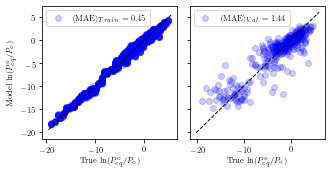

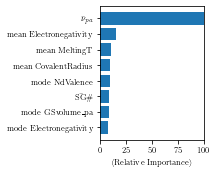

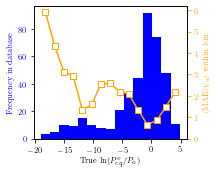

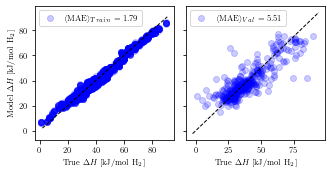

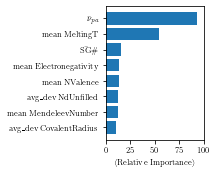

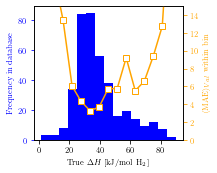

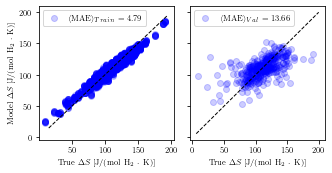

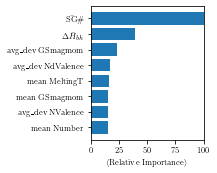

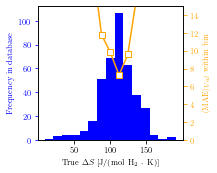

(3090, 3090, 3090) (690, 690, 690)


In [11]:
plot_summary(estplus_lnPeqo,savename='figures/lnPeqo_plus_summary.png',prettify_Magpie=True)
plot_summary(estplus_dH,savename='figures/dH_plus_summary.png',prettify_Magpie=True)
plot_summary(estplus_dS,savename='figures/dS_plus_summary.png',prettify_Magpie=True)

vertical_img_concat(['figures/lnPeqo_plus_summary.png',
                     'figures/dH_plus_summary.png',
                     'figures/dS_plus_summary.png'],
                    savename='figures/SI-all_training_summary.png')

Primary feature:   mean GSvolume_pa
MAE in 'LnEquilibrium_Pressure_25C' linear model with ' mean GSvolume_pa' feature:  2.5827496232766074
R^2 in 'LnEquilibrium_Pressure_25C' linear model with ' mean GSvolume_pa' feature:  0.005795105939864098
Primary feature:   mean GSvolume_pa
MAE in 'Heat_of_Formation_kJperMolH2' linear model with ' mean GSvolume_pa' feature:  8.792600208926329
R^2 in 'Heat_of_Formation_kJperMolH2' linear model with ' mean GSvolume_pa' feature:  -0.539742511467501
Primary feature:   mean SpaceGroupNumber
MAE in 'Entropy_of_Formation_kJperMolH2perK' linear model with ' mean SpaceGroupNumber' feature:  16.123697040010963
R^2 in 'Entropy_of_Formation_kJperMolH2perK' linear model with ' mean SpaceGroupNumber' feature:  -7.106321330364118


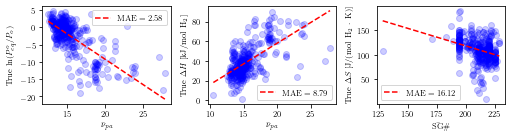

In [12]:
def lin_reg_primary_feature(model,ax):

    all_feature_importance = np.sum(model._all_feature_importance, axis=0)
    all_feature_importance/=(model._nsplits)
    sorted_idx = np.argsort(all_feature_importance)

    primary = model._allX.columns[sorted_idx[-1]]
    print("Primary feature: ", primary)
    X = np.array(model._X[:,sorted_idx[-1]]).reshape(-1,1)
    y = model._y
    fit, r2, pred, inds = sk_linear_model(X,y)
    MAE=np.mean(np.abs(pred-model._y))
    print("MAE in '%s' linear model with '%s' feature: "%(model._predict_column,primary),MAE)
    print("R^2 in '%s' linear model with '%s' feature: "%(model._predict_column,primary),r2)
    
    ax.scatter(X.squeeze(),y,c='blue',alpha=0.2)
    inds=X.squeeze().argsort()
    ax.plot(X.squeeze()[inds],pred[inds],c='r',linestyle='--',label=r'$\textrm{MAE}=%0.2f$'%MAE)
    return primary
    
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(7,1.8),constrained_layout=True)

primary = lin_reg_primary_feature(estplus_lnPeqo,ax[0])
ax[0].set_xlabel(prettify_magpie_v3(primary))
ax[0].set_ylabel(r"True %s"%column_to_label(estplus_lnPeqo._predict_column))
ax[0].legend(loc='best',prop={'size':8})

primary = lin_reg_primary_feature(estplus_dH,ax[1])
ax[1].set_xlabel(prettify_magpie_v3(primary))
ax[1].set_ylabel(r"True %s"%column_to_label(estplus_dH._predict_column))
ax[1].legend(loc='best',prop={'size':8})

primary = lin_reg_primary_feature(estplus_dS,ax[2])
ax[2].set_xlabel(prettify_magpie_v3(primary))
ax[2].set_ylabel(r"True %s"%column_to_label(estplus_dS._predict_column))
ax[2].legend(loc='best',prop={'size':8})

plt.savefig('figures/SI-linear_model_summary.png')

## 5.2. Apply model to list of experimental HEAs

In [13]:
df_exp = pd.read_csv('experiments/HEA_experiments_select.csv')
aug_features_exp = magpie_featurize_data(df_exp,elem_prop=elem_Ef_MP)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


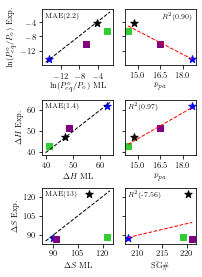

In [14]:
lnPeqo_exp_predict = estplus_lnPeqo._finalest.predict(aug_features_exp)
dH_exp_predict = estplus_dH._finalest.predict(aug_features_exp)
dS_exp_predict = estplus_dS._finalest.predict(aug_features_exp)

fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(2.7,3.7),constrained_layout = True,sharey='row')

markerlist = ['*','s','*','s']
clist = ['blue','limegreen','black','purple']
sizes = [60,30,60,30]

########### Peq plots ##########
errors = []
for i, (mark, color,size) in enumerate(zip(markerlist, clist,sizes)):
    errors.append(lnPeqo_exp_predict[i]-df_exp['LnEquilibrium_Pressure_25C'][i])
    MAE = np.mean(np.abs(errors))
    if i == len(markerlist)-1:
        label = r'$\textrm{MAE(%.1f)}$'%MAE
    else:
        label = None
    ax[0,0].scatter(lnPeqo_exp_predict[i],df_exp['LnEquilibrium_Pressure_25C'][i],
                    marker=mark,color=color,s=size,label=label)
draw_y_equals_x_v2(ax[0,0])
ax[0,0].xaxis.set_major_locator(plt.MaxNLocator(4))
ax[0,0].yaxis.set_major_locator(plt.MaxNLocator(4))
ax[0,0].set_ylabel(r'$\ln (P_{eq}^o/P_o)\textrm{ Exp.}$')
ax[0,0].set_xlabel(r'$\ln (P_{eq}^o/P_o)\textrm{ ML}$')
leg = ax[0,0].legend(loc='best',handlelength=0, handletextpad=0, fancybox=True,borderaxespad=0,
                     prop={'size':7},frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)
    
    
X = np.array(aug_features_exp[' mean GSvolume_pa']).reshape(-1,1)
y = df_exp['LnEquilibrium_Pressure_25C']
fit, r2, pred, inds = sk_linear_model(X,y)

ax[0,1].plot(X[inds], pred[inds], color='red', linewidth=1, linestyle='--')
for i, (mark, color,size) in enumerate(zip(markerlist, clist,sizes)): 
    if i == len(markerlist)-1:
        label = r'$R^2\textrm{(%.2f)}$'%r2
    else:
        label = None
    ax[0,1].scatter(aug_features_exp[' mean GSvolume_pa'][i],
                    df_exp['LnEquilibrium_Pressure_25C'][i],
                    marker=mark,color=color,s=size,label=label)
ax[0,1].xaxis.set_major_locator(plt.MaxNLocator(4))
ax[0,1].yaxis.set_major_locator(plt.MaxNLocator(4))
ax[0,1].set_xlabel(r'$\bar{\nu}_{pa}$')
leg = ax[0,1].legend(loc='best',handlelength=0, handletextpad=0, fancybox=True,borderaxespad=0,
                     prop={'size':7},frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)


########## dH plots ###########
errors = []
for i, (mark, color,size) in enumerate(zip(markerlist, clist,sizes)):
    errors.append(dH_exp_predict[i]-df_exp['Heat_of_Formation_kJperMolH2'][i])
    MAE = np.mean(np.abs(errors))
    if i == len(markerlist)-1:
        label = r'$\textrm{MAE(%.1f)}$'%MAE
    else:
        label = None
    ax[1,0].scatter(dH_exp_predict[i],
                    df_exp['Heat_of_Formation_kJperMolH2'][i],
                    marker=mark,color=color,s=size,label=label)
draw_y_equals_x_v2(ax[1,0])
ax[1,0].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[1,0].yaxis.set_major_locator(plt.MaxNLocator(3))
ax[1,0].set_ylabel(r'$\Delta H~\textrm{Exp.}$')
ax[1,0].set_xlabel(r'$\Delta H~\textrm{ML}$')
leg = ax[1,0].legend(loc='best',handlelength=0, handletextpad=0, fancybox=True,borderaxespad=0,
                     prop={'size':7},frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)

X = np.array(aug_features_exp[' mean GSvolume_pa']).reshape(-1,1)
y = df_exp['Heat_of_Formation_kJperMolH2']
fit, r2, pred, inds = sk_linear_model(X,y)

ax[1,1].plot(X[inds], pred[inds], color='red', linewidth=1, linestyle='--')
for i, (mark, color,size) in enumerate(zip(markerlist, clist,sizes)): 
    if i == len(markerlist)-1:
        label = r'$R^2\textrm{(%.2f)}$'%r2
    else:
        label = None
    ax[1,1].scatter(aug_features_exp[' mean GSvolume_pa'][i],
                    df_exp['Heat_of_Formation_kJperMolH2'][i],
                    marker=mark,color=color,s=size,label=label)
ax[1,1].xaxis.set_major_locator(plt.MaxNLocator(4))
ax[1,1].yaxis.set_major_locator(plt.MaxNLocator(3))
ax[1,1].set_xlabel(r'$\bar{\nu}_{pa}$')
leg = ax[1,1].legend(loc='best',handlelength=0, handletextpad=0, fancybox=True,borderaxespad=0,
                     prop={'size':7},frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)



########## dS plots ###########
errors = []
for i, (mark, color,size) in enumerate(zip(markerlist, clist,sizes)):
    errors.append(dS_exp_predict[i]-df_exp['Entropy_of_Formation_kJperMolH2perK'][i])
    MAE = np.mean(np.abs(errors))
    if i == len(markerlist)-1:
        label = r'$\textrm{MAE(%.0f)}$'%MAE
    else:
        label = None
    ax[2,0].scatter(dS_exp_predict[i],
                    df_exp['Entropy_of_Formation_kJperMolH2perK'][i],
                    marker=mark,color=color,s=size,label=label)
draw_y_equals_x_v2(ax[2,0])
ax[2,0].xaxis.set_major_locator(plt.MaxNLocator(4))
ax[2,0].yaxis.set_major_locator(plt.MaxNLocator(4))
ax[2,0].set_ylabel(r'$\Delta S~\textrm{Exp.}$')
ax[2,0].set_xlabel(r'$\Delta S~\textrm{ML}$')
leg = ax[2,0].legend(loc='upper left',handlelength=0, handletextpad=0, fancybox=True,borderaxespad=0,
                     prop={'size':7},frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)


X = np.array(aug_features_exp[' mean SpaceGroupNumber']).reshape(-1,1)
y = df_exp['Entropy_of_Formation_kJperMolH2perK']
fit, r2, pred, inds = sk_linear_model(X,y)

ax[2,1].plot(X[inds], pred[inds], color='red', linewidth=1, linestyle='--')
for i, (mark, color,size) in enumerate(zip(markerlist, clist,sizes)):
    if i == len(markerlist)-1:
        label = r'$R^2\textrm{(%.2f)}$'%r2
    else:
        label = None
    ax[2,1].scatter(aug_features_exp[' mean SpaceGroupNumber'][i],
                    df_exp['Entropy_of_Formation_kJperMolH2perK'][i],
                    marker=mark,color=color,s=size, label=label)
    
ax[2,1].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[2,1].yaxis.set_major_locator(plt.MaxNLocator(4))
ax[2,1].set_xlabel(r'$\bar{\textrm{SG}}\#$')
leg = ax[2,1].legend(loc='upper left',handlelength=0, handletextpad=0, fancybox=True,borderaxespad=0,
                     prop={'size':7},frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)


plt.savefig('figures/exp_vs_ML_thermo.pdf')
plt.show()

#print(plt.rcParams)

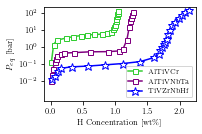

In [15]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(2.7,1.75),constrained_layout = True)

AlTiVCr_PCT = pd.read_csv('experiments/AlTiVCr_PCT.csv')
AlTiVCr_vH = pd.read_csv('experiments/AlTiVCr_vH.csv')

AlTiVNbTa_PCT = pd.read_csv('experiments/AlTiVNbTa_PCT.csv')
AlTiVNbTa_vH = pd.read_csv('experiments/AlTiVNbTa_vH.csv')

TiVZrNbHf_PCT = pd.read_csv('experiments/TiVZrNbHf_PCT.csv')
TiVZrNbHf_vH = pd.read_csv('experiments/TiVZrNbHf_vH.csv')

ax.plot(AlTiVCr_PCT['Conc. wt% H'],AlTiVCr_PCT['P(eq.), bar'],c='limegreen',
        marker='s',markersize=5,markerfacecolor='white',label='AlTiVCr')
ax.plot(AlTiVNbTa_PCT['Conc, wt%'],AlTiVNbTa_PCT['Peq, bar'],c='purple',
        marker='s',markersize=5,markerfacecolor='white',label='AlTiVNbTa')
ax.plot(TiVZrNbHf_PCT['Conc, wt%'],TiVZrNbHf_PCT['P(eq.), bar'],c='blue',
        marker='*',markersize=9,markerfacecolor='white',label='TiVZrNbHf')
ax.set_yscale('log')
ax.yaxis.set_ticks([1e-2,1e-1,1e0,1e1,1e2])
ax.set_xlabel(r'$\textrm{H Concentration [wt\%]}$')
ax.set_ylabel(r'$P_{eq}\textrm{ [bar]}$')
ax.set_ylim((.7e-3,None))
ax.legend(loc='lower right',prop={'size':7})#,bbox_to_anchor=[1.02,1.0])

plt.savefig('figures/PCT_final.pdf')

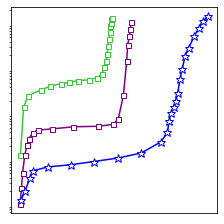

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3,3),constrained_layout = True)

ax.plot(AlTiVCr_PCT['Conc. wt% H'],AlTiVCr_PCT['P(eq.), bar'],c='limegreen',
        marker='s',markersize=5,markerfacecolor='white',label='AlTiVCr')
ax.plot(AlTiVNbTa_PCT['Conc, wt%'],AlTiVNbTa_PCT['Peq, bar'],c='purple',
        marker='s',markersize=5,markerfacecolor='white',label='AlTiVNbTa')
ax.plot(TiVZrNbHf_PCT['Conc, wt%'],TiVZrNbHf_PCT['P(eq.), bar'],c='blue',
        marker='*',markersize=9,markerfacecolor='white',label='TiVZrNbHf')
ax.set_yscale('log')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.savefig('figures/PCT_TOC.pdf')

[-44.26159118] 90.93466329878302
[-51.28981064] 87.15950609014666
[-60.86158827] 87.9005956948842


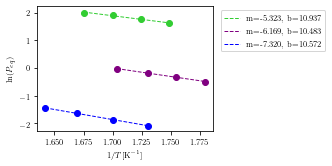

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4.5,2.2),constrained_layout = True)

x=AlTiVCr_vH['1/T']
y=AlTiVCr_vH['Ln(Peq)']
X = np.array(x).reshape(-1,1)
inds = np.argsort(X,axis=0).squeeze()
fit = linear_model.LinearRegression().fit(X,y)
print(fit.coef_*8.31441,fit.intercept_*8.31441)
pred = fit.predict(X)
ax.scatter(x,y,c='limegreen')
ax.plot(X[inds], pred[inds], color='limegreen', linewidth=1, linestyle='--',
       label=r'$\textrm{m=%.3f, b=%.3f}$'%(fit.coef_,fit.intercept_))

# x=AlTiVCr_vH['1/T'][:-1]
# y=AlTiVCr_vH['Ln(Peq)'][:-1]
# X = np.array(x).reshape(-1,1)
# inds = np.argsort(X,axis=0).squeeze()
# fit = linear_model.LinearRegression().fit(X,y)
# print(fit.coef_*8.31441,fit.intercept_*8.31441)

# x=AlTiVCr_vH['1/T'][1:]
# y=AlTiVCr_vH['Ln(Peq)'][1:]
# X = np.array(x).reshape(-1,1)
# inds = np.argsort(X,axis=0).squeeze()
# fit = linear_model.LinearRegression().fit(X,y)
# print(fit.coef_*8.31441,fit.intercept_*8.31441)

x=AlTiVNbTa_vH['1/T']
y=AlTiVNbTa_vH['Ln(Peq)']
X = np.array(x).reshape(-1,1)
inds = np.argsort(X,axis=0).squeeze()
fit = linear_model.LinearRegression().fit(X,y)
print(fit.coef_*8.31441,fit.intercept_*8.31441)
pred = fit.predict(X)
ax.scatter(x,y,c='purple')
ax.plot(X[inds], pred[inds], color='purple', linewidth=1, linestyle='--',
        label=r'$\textrm{m=%.3f, b=%.3f}$'%(fit.coef_,fit.intercept_))

# x=AlTiVNbTa_vH['1/T'][:-1]
# y=AlTiVNbTa_vH['Ln(Peq)'][:-1]
# X = np.array(x).reshape(-1,1)
# inds = np.argsort(X,axis=0).squeeze()
# fit = linear_model.LinearRegression().fit(X,y)
# print(fit.coef_*8.31441,fit.intercept_*8.31441)

# x=AlTiVNbTa_vH['1/T'][1:]
# y=AlTiVNbTa_vH['Ln(Peq)'][1:]
# X = np.array(x).reshape(-1,1)
# inds = np.argsort(X,axis=0).squeeze()
# fit = linear_model.LinearRegression().fit(X,y)
# print(fit.coef_*8.31441,fit.intercept_*8.31441)

x=TiVZrNbHf_vH['1/T']
y=TiVZrNbHf_vH['Ln(Peq)']
X = np.array(x).reshape(-1,1)
inds = np.argsort(X,axis=0).squeeze()
fit = linear_model.LinearRegression().fit(X,y)
print(fit.coef_*8.31446261815324,fit.intercept_*8.31446261815324)
pred = fit.predict(X)
ax.scatter(x,y,c='blue')
ax.plot(X[inds], pred[inds], color='blue', linewidth=1, linestyle='--',
        label=r'$\textrm{m=%.3f, b=%.3f}$'%(fit.coef_,fit.intercept_))

# x=TiVZrNbHf_vH['1/T'][:-1]
# y=TiVZrNbHf_vH['Ln(Peq)'][:-1]
# X = np.array(x).reshape(-1,1)
# inds = np.argsort(X,axis=0).squeeze()
# fit = linear_model.LinearRegression().fit(X,y)
# print(fit.coef_*8.31441,fit.intercept_*8.31441)

# x=TiVZrNbHf_vH['1/T'][1:]
# y=TiVZrNbHf_vH['Ln(Peq)'][1:]
# X = np.array(x).reshape(-1,1)
# inds = np.argsort(X,axis=0).squeeze()
# fit = linear_model.LinearRegression().fit(X,y)
# print(fit.coef_*8.31441,fit.intercept_*8.31441)

ax.set_xlabel(r'$1/T \textrm{[K}^{-1}\textrm{]}$')
ax.set_ylabel(r'$\ln(P_{eq})$')
ax.legend(loc='upper left',bbox_to_anchor=[1.02,1])

plt.savefig('figures/SI-vH_final.pdf')



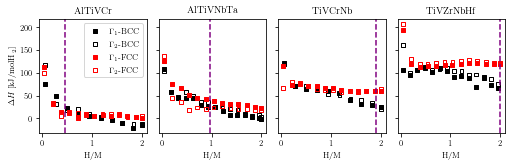

In [18]:
fig, ax = plt.subplots(nrows=1,ncols=4, sharey=True, sharex=True,figsize=(7,2.2),constrained_layout=True)

AlTiVCr_76_BCC = pd.read_csv('dft_data/AlTiVCr-76-BCC.csv') # lowest E
AlTiVCr_11_BCC = pd.read_csv('dft_data/AlTiVCr-11-BCC.csv')

AlTiVCr_61_FCC = pd.read_csv('dft_data/AlTiVCr-61-FCC.csv') # lowest E
AlTiVCr_44_FCC = pd.read_csv('dft_data/AlTiVCr-44-FCC.csv')

AlTiVNbTa_77_BCC = pd.read_csv('dft_data/AlTiVNbTa-77-BCC.csv') # lowest E
AlTiVNbTa_32_BCC = pd.read_csv('dft_data/AlTiVNbTa-32-BCC.csv')

AlTiVNbTa_92_FCC = pd.read_csv('dft_data/AlTiVNbTa-92-FCC.csv') # lowest E
AlTiVNbTa_64_FCC = pd.read_csv('dft_data/AlTiVNbTa-64-FCC.csv')

TiVCrNb_100_BCC = pd.read_csv('dft_data/TiVCrNb-100-BCC.csv') # lowest E
TiVCrNb_68_BCC = pd.read_csv('dft_data/TiVCrNb-68-BCC.csv')

TiVCrNb_76_FCC = pd.read_csv('dft_data/TiVCrNb-76-FCC.csv') # lowest E
TiVCrNb_18_FCC = pd.read_csv('dft_data/TiVCrNb-18-FCC.csv')

TiVZrNb_211_BCC = pd.read_csv('dft_data/TiVZrNb-211-BCC.csv') # lowest E
TiVZrNb_279_BCC = pd.read_csv('dft_data/TiVZrNb-279-BCC.csv')

TiVZrNb_72_FCC = pd.read_csv('dft_data/TiVZrNb-72-FCC.csv') # lowest E
TiVZrNb_22_FCC = pd.read_csv('dft_data/TiVZrNb-22-FCC.csv')

TiVZrNbHf_178_20_BCC = pd.read_csv('dft_data/TiVZrNbHf-178-20-BCC.csv') # lowest E
TiVZrNbHf_188_BCC = pd.read_csv('dft_data/TiVZrNbHf-188-BCC.csv')

TiVZrNbHf_70_FCC = pd.read_csv('dft_data/TiVZrNbHf-70-FCC.csv') # lowest E
TiVZrNbHf_15_FCC = pd.read_csv('dft_data/TiVZrNbHf-15-FCC.csv')

def dft_ax_plot(ax,data,leg=False,text=None):
    size=15
    ax.scatter(data[0][0],-1*data[0][1],
               c='black',marker='s',s=size,label=r'$\Gamma_1\textrm{-BCC}$')
    ax.scatter(data[1][0],-1*data[1][1],
               edgecolors='black',marker='s',s=size,facecolors='none',label=r'$\Gamma_2\textrm{-BCC}$')
    ax.scatter(data[2][0],-1*data[2][1],
               c='red',marker='s',s=size,label=r'$\Gamma_1\textrm{-FCC}$')
    ax.scatter(data[3][0],-1*data[3][1],
               edgecolors='red',marker='s',s=size,facecolors='none',label=r'$\Gamma_2\textrm{-FCC}$')
    if leg:
        ax.legend(loc='upper right',prop={'size':8})
    if text is not None:
        #ax.text(0,0,text,transform=ax.transAxes)
        ax.set_title(text)


data = []
data.append((AlTiVCr_76_BCC['H/M'],AlTiVCr_76_BCC['DH (kJ/mol)']))
data.append((AlTiVCr_11_BCC['H/M'],AlTiVCr_11_BCC['DH (kJ/mol)']))
data.append((AlTiVCr_61_FCC['H/M'],AlTiVCr_61_FCC['DH (kJ/mol)']))
data.append((AlTiVCr_44_FCC['H/M'],AlTiVCr_44_FCC['DH (kJ/mol)']))
#ax = ax[0,0]
axc=ax[0]
dft_ax_plot(axc,data,leg=True,text=r'$\textrm{AlTiVCr}$')

data=[]
data.append((AlTiVNbTa_77_BCC['H/M'],AlTiVNbTa_77_BCC['DH (kJ/mol)']))
data.append((AlTiVNbTa_32_BCC['H/M'],AlTiVNbTa_32_BCC['DH (kJ/mol)']))
data.append((AlTiVNbTa_92_FCC['H/M'],AlTiVNbTa_92_FCC['DH (kJ/mol)']))
data.append((AlTiVNbTa_64_FCC['H/M'],AlTiVNbTa_64_FCC['DH (kJ/mol)']))
#ax=ax[0,1]
axc=ax[1]
dft_ax_plot(axc,data,text=r'$\textrm{AlTiVNbTa}$')

# data=[]
# data.append((TiVZrNb_211_BCC['H/M'],TiVZrNb_211_BCC['DH (kJ/mol)']))
# data.append((TiVZrNb_279_BCC['H/M'],TiVZrNb_279_BCC['DH (kJ/mol)']))
# data.append((TiVZrNb_72_FCC['H/M'],TiVZrNb_72_FCC['DH (kJ/mol)']))
# data.append((TiVZrNb_22_FCC['H/M'],TiVZrNb_22_FCC['DH (kJ/mol)']))
# #ax=ax[1,0]
# axc=ax[2]
# dft_ax_plot(axc,data,text=r'$\textrm{TiVZrNb}$')

data=[]
data.append((TiVCrNb_100_BCC['H/M'],TiVCrNb_100_BCC['DH (kJ/mol)']))
data.append((TiVCrNb_68_BCC['H/M'],TiVCrNb_68_BCC['DH (kJ/mol)']))
data.append((TiVCrNb_76_FCC['H/M'],TiVCrNb_76_FCC['DH (kJ/mol)']))
data.append((TiVCrNb_18_FCC['H/M'],TiVCrNb_18_FCC['DH (kJ/mol)']))
#ax=ax[1,0]
axc=ax[2]
dft_ax_plot(axc,data,text=r'$\textrm{TiVCrNb}$')

data=[]
data.append((TiVZrNbHf_178_20_BCC['H/M'],TiVZrNbHf_178_20_BCC['DH (kJ/mol)']))
data.append((TiVZrNbHf_188_BCC['H/M'],TiVZrNbHf_188_BCC['DH (kJ/mol)']))
data.append((TiVZrNbHf_70_FCC['H/M'],TiVZrNbHf_70_FCC['DH (kJ/mol)']))
data.append((TiVZrNbHf_15_FCC['H/M'],TiVZrNbHf_15_FCC['DH (kJ/mol)']))
#ax=ax[1,1]
axc=ax[3]
dft_ax_plot(axc,data,text=r'$\textrm{TiVZrNbHf}$')

ylim = ax[0].get_ylim()
ax[0].plot([0.45,0.45],ylim,c='purple',linestyle='--')
ax[1].plot([0.96,0.96],ylim,c='purple',linestyle='--')
ax[2].plot([1.9,1.9],ylim,c='purple',linestyle='--')
ax[3].plot([1.99,1.99],ylim,c='purple',linestyle='--')
ax[0].set_ylim(ylim)


ax[0].set_ylabel(r'$\Delta H \textrm{ [kJ/molH}_2\textrm{]}$')
ax[0].set_xlabel(r'$\textrm{H/M}$')
ax[1].set_xlabel(r'$\textrm{H/M}$')
ax[2].set_xlabel(r'$\textrm{H/M}$')
ax[3].set_xlabel(r'$\textrm{H/M}$')
# ax[1,0].set_ylabel(r'$\Delta H \textrm{ [kJ/molH}_2\textrm{]}$')
# ax[1,0].set_xlabel(r'$\textrm{H/M}$')
plt.savefig('figures/dft_final.pdf')



In [19]:
def HtoM_from_wtfrac(wtfrac,alloyMW):
    molefrac = wtfrac*np.sum(alloyMW)/(1.008*(1-wtfrac))
    HtoM = molefrac/len(alloyMW)
    return HtoM

print(HtoM_from_wtfrac(0.01,[26.9815384,47.867,50.9415,51.9961]))
print(HtoM_from_wtfrac(0.012,[26.9815384,47.867,50.9415,92.90638,180.94788]))
print(HtoM_from_wtfrac(0.022,[47.867,50.9415,91.224,92.90638,178.49]))
print(HtoM_from_wtfrac(0.088,[47.867,47.867,12.011,19.998]))

0.44539176086259413
0.9630911374590323
2.0594822929853605
3.0570632309941517


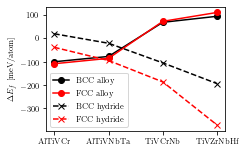

In [20]:
df = pd.read_csv('dft_data/ref_ener.csv')

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,2.0),constrained_layout=True)

df['PymComp'] = [pym.Composition(s) for s in df['Comp']]

# strips H from the composition then orders atomic strings by atomic number
df['ElStr'] = ["".join([str(e) for e in sorted([el for el in c.elements if str(el) !='H'], key=lambda x: x.number)]) 
               for c in df['PymComp']]

BCC_alloy_ind = (['H' not in c for c in df['PymComp']]) & (df['Lattice'] == 'BCC')
FCC_alloy_ind = (['H' not in c for c in df['PymComp']]) & (df['Lattice'] == 'FCC')
BCC_hydride_ind = (['H' in c for c in df['PymComp']]) & (df['Lattice'] == 'BCC')
FCC_hydride_ind = (['H' in c for c in df['PymComp']]) & (df['Lattice'] == 'FCC')

BCC_alloy = df.loc[BCC_alloy_ind]
comp_order = list(BCC_alloy['ElStr'])

FCC_alloy = df.loc[FCC_alloy_ind]

BCC_hydride = df.loc[BCC_hydride_ind]

FCC_hydride = df.loc[FCC_hydride_ind]

xvals = [i for i in range(len(BCC_alloy['PymComp']))]
ax.plot(xvals,BCC_alloy['dE_meVperAtom'],c='black',marker='o',label=r'$\textrm{BCC alloy}$')
ax.plot(xvals,FCC_alloy['dE_meVperAtom'],c='red',marker='o',label=r'$\textrm{FCC alloy}$')
ax.plot(xvals,BCC_hydride['dE_meVperAtom'],c='black',marker='x',linestyle='--',label=r'$\textrm{BCC hydride}$')
ax.plot(xvals,FCC_hydride['dE_meVperAtom'],c='red',marker='x',linestyle='--',label=r'$\textrm{FCC hydride}$')

ax.set_ylabel(r'$\Delta E_f\textrm{ [meV/atom]}$')

ax.legend(loc='best')

ax.xaxis.set_ticks(xvals)
ax.xaxis.set_ticklabels(BCC_alloy['ElStr'])

plt.savefig('figures/dft_stability.pdf')

## 5.3. Screen rHEA with all models

### 5.3.1. Prep the dataset

In [21]:
# Initialize the compositions for rHEA dataset
allels = set(("Nb","Mo","Ti","Hf","Pd","Al","Zr","Cr","Ta","V"))
comb1 = combinations(allels,4)
comb2 = combinations(allels,5)
comb3 = combinations(allels,6)
allcombinations = list(comb1)+list(comb2)+list(comb3)
allcompositions = ["".join(c) for c in allcombinations]

# Get the MW of each compound
allpymcomps=[pym.core.Composition(c) for c in allcompositions]
allweights = np.array([c.weight/len(b) for c,b in zip(allpymcomps,allcombinations)])

In [22]:
df_rHEA = pd.DataFrame(allcompositions,columns=["Composition_Formula"])
aug_features_rHEA = magpie_featurize_data(df_rHEA,elem_prop=elem_Ef_MP)

In [23]:
# just the rHEA features for future use
features_rHEA = magpie_featurize_data(df_rHEA,keep_comp_col=True,elem_prop=None)
#features_rHEA.to_csv('rHEA_features.csv')

### 5.3.2. Compare the model trained on HydPARK vs HydPARK+

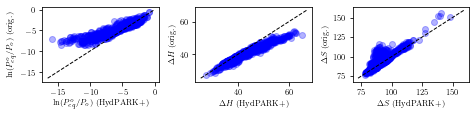

In [24]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(6.5,1.5),constrained_layout = True)

ax = axs[0]
x = estplus_lnPeqo._finalest.predict(aug_features_rHEA)
y = est_lnPeqo._finalest.predict(aug_features_rHEA)
ax.scatter(x, y, c='blue', edgecolor='blue', linewidths=1, alpha=0.3,
           label=r"$\textrm{rHEA compositions}$")
draw_y_equals_x_v2(ax)

ax.set_xlabel(r'$\ln (P_{eq}^o/P_o)~(\textrm{HydPARK+})$')
ax.set_ylabel(r'$\ln (P_{eq}^o/P_o)~(\textrm{orig.})$')
#ax.legend(loc='lower left',prop={'size':8},bbox_to_anchor=(0,1.01))
#ax.text(x=-.5, y=0.5, s=r'$\textrm{(b)}$', transform = ax.transAxes)

ax = axs[1]
x = estplus_dH._finalest.predict(aug_features_rHEA)
y = est_dH._finalest.predict(aug_features_rHEA)
ax.scatter(x, y, c='blue', edgecolor='blue', linewidths=1, alpha=0.3,
           label=r"$\textrm{rHEA compositions}$")
draw_y_equals_x_v2(ax)

ax.set_xlabel(r'$\Delta H~(\textrm{HydPARK+})$')
ax.set_ylabel(r'$\Delta H~(\textrm{orig.})$')

ax = axs[2]
x = estplus_dS._finalest.predict(aug_features_rHEA)
y = est_dS._finalest.predict(aug_features_rHEA)
ax.scatter(x, y, c='blue', edgecolor='blue', linewidths=1, alpha=0.3,
           label=r"$\textrm{rHEA compositions}$")
draw_y_equals_x_v2(ax)

ax.set_xlabel(r'$\Delta S~(\textrm{HydPARK+})$')
ax.set_ylabel(r'$\Delta S~(\textrm{orig.})$')

plt.savefig('figures/comparison_HydParkplus.pdf')
plt.show()

Index(['Material_Class', 'Composition_Formula', 'Hydrogen_Weight_Percent',
       'Heat_of_Formation_kJperMolH2', 'Temperature_oC',
       'Pressure_Atmospheres_Absolute', 'Original_Composition_Formula',
       'Entropy_of_Formation_kJperMolH2perK', 'Equilibrium_Pressure_25C',
       'LnEquilibrium_Pressure_25C'],
      dtype='object')


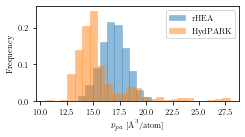

In [25]:
vals, bins = np.histogram(aug_features_rHEA[' mean GSvolume_pa'])
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3.3,1.8),constrained_layout=True)
ax.hist(bins[:-1], bins = bins, weights=vals/sum(vals),alpha=0.5,
        edgecolor=DEFCOLS[0],linewidth=.5,label='rHEA')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'$\bar{\nu}_{pa}\textrm{ [\AA}^3\textrm{/atom]}$')

print(df_train.columns)
vals, bins = np.histogram(aug_features_train[' mean GSvolume_pa'],bins=25)
ax.hist(bins[:-1], bins = bins, weights=vals/sum(vals),alpha=0.5,
        edgecolor=DEFCOLS[1],linewidth=.5,label='HydPARK')
ax.legend(loc='best')

plt.savefig('figures/comparison_HydPark_nupa.png',dpi=300)

### 5.3.3. Visualize the distribution mismatch between HydPARK and rHEA predictions

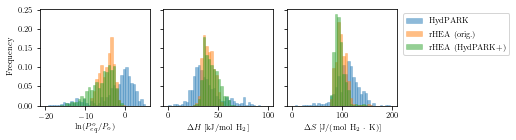

In [26]:
lnPbins = np.linspace(-20,5,41)
lnP_hyd_vals, _ = np.histogram(df_orig['LnEquilibrium_Pressure_25C'],
                                 bins = lnPbins)
lnP_estplus_vals, _ = np.histogram(estplus_lnPeqo._finalest.predict(aug_features_rHEA),
                                     bins = lnPbins)
lnP_est_vals, _ = np.histogram(est_lnPeqo._finalest.predict(aug_features_rHEA),
                                 bins = lnPbins)

dHbins = np.linspace(0,100,41)
dH_hyd_vals, _ = np.histogram(df_orig['Heat_of_Formation_kJperMolH2'],
                                 bins = dHbins)
dH_estplus_vals, _ = np.histogram(estplus_dH._finalest.predict(aug_features_rHEA),
                                     bins = dHbins)
dH_est_vals, _ = np.histogram(est_dH._finalest.predict(aug_features_rHEA),
                                 bins = dHbins)

dSbins = np.linspace(0,200,41)
dS_hyd_vals, _ = np.histogram(df_orig['Entropy_of_Formation_kJperMolH2perK'],
                                 bins = dSbins)
dS_estplus_vals, _ = np.histogram(estplus_dS._finalest.predict(aug_features_rHEA),
                                     bins = dSbins)
dS_est_vals, _ = np.histogram(est_dS._finalest.predict(aug_features_rHEA),
                                 bins = dSbins)

fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(7,1.8),constrained_layout=True,sharey=True)

ax=axs[0]
b = lnPbins
ax.hist(b[:-1], bins = b, weights=lnP_hyd_vals/sum(lnP_hyd_vals),alpha=0.5,
        edgecolor=DEFCOLS[0],linewidth=.5)
ax.hist(b[:-1], bins = b, weights=lnP_est_vals/sum(lnP_est_vals),alpha=0.5,
        edgecolor=DEFCOLS[1],linewidth=.5)
ax.hist(b[:-1], bins = b, weights=lnP_estplus_vals/sum(lnP_estplus_vals),alpha=0.5,
        edgecolor=DEFCOLS[2],linewidth=.5)
ax.set_ylabel(r'$\textrm{Frequency}$')
ax.set_xlabel(column_to_label('LnEquilibrium_Pressure_25C'))

ax = axs[1]
b = dHbins
ax.hist(b[:-1], bins = b, weights=dH_hyd_vals/sum(dH_hyd_vals),alpha=0.5,
        edgecolor=DEFCOLS[0], linewidth=.5)
ax.hist(b[:-1], bins = b, weights=dH_est_vals/sum(dH_est_vals),alpha=0.5,
        edgecolor=DEFCOLS[1], linewidth=.5)
ax.hist(b[:-1], bins = b, weights=dH_estplus_vals/sum(dH_estplus_vals),alpha=0.5,
        edgecolor=DEFCOLS[2], linewidth=.5)
ax.set_xlabel(column_to_label('Heat_of_Formation_kJperMolH2'))

ax = axs[2]
b = dSbins
ax.hist(b[:-1], bins = b, weights=dS_hyd_vals/sum(dS_hyd_vals),alpha=0.5,
        edgecolor=DEFCOLS[0], linewidth=.5, label=r'$\textrm{HydPARK}$')
ax.hist(b[:-1], bins = b, weights=dS_est_vals/sum(dS_est_vals),alpha=0.5,
        edgecolor=DEFCOLS[1],linewidth=.5, label=r'$\textrm{rHEA (orig.)}$')
ax.hist(b[:-1], bins = b, weights=dS_estplus_vals/sum(dS_estplus_vals),alpha=0.5,
        edgecolor=DEFCOLS[2], linewidth=.5, label=r'$\textrm{rHEA (HydPARK+)}$')
ax.set_xlabel(column_to_label('Entropy_of_Formation_kJperMolH2perK'))
ax.legend(loc='upper left',bbox_to_anchor=(1.02,1.0),prop={'size':8})

plt.savefig('figures/dist_mismatch.png',dpi=300)

### 5.3.4. Screen all rHEA with ML models

In [27]:
lnPeqo_rHEA_predict = estplus_lnPeqo._finalest.predict(aug_features_rHEA)
dH_rHEA_predict = estplus_dH._finalest.predict(aug_features_rHEA)
dS_rHEA_predict = estplus_dS._finalest.predict(aug_features_rHEA)

MAE in lnPeq of linear model with nu_pa:  1.9072309882836802
MAE in dH of linear model with nu_pa:  1.9072309882836802
['Nb', 'Ti', 'Zr', 'Hf'] , 102.62184500000001 , 20.1 , 4.25 , -14.1
['Nb', 'Ti', 'Zr', 'Hf', 'Ta'] , 118.28705199999999 , 19.7 , 4.40 , -12.7
['Nb', 'Ti', 'V', 'Zr', 'Hf'] , 92.28577600000001 , 18.7 , 4.40 , -14.6
['Nb', 'Ti', 'V', 'Hf'] , 92.55122 , 17.5 , 4.50 , -14.5
['Nb', 'Ti', 'V', 'Zr'] , 70.73472000000001 , 17.8 , 4.50 , -15.8
['Nb', 'Ti', 'V', 'Ta'] , 93.16569 , 16.5 , 4.75 , -8.2
['Nb', 'Ti', 'V', 'Cr', 'Ta'] , 84.931772 , 15.4 , 5.00 , -6.0
['Nb', 'Ti', 'V', 'Cr'] , 60.927744999999994 , 14.8 , 5.00 , -4.1
['Nb', 'Ti', 'V', 'Cr', 'Mo'] , 67.930196 , 15.0 , 5.20 , -3.0
['Ti', 'V', 'Cr', 'Mo'] , 61.68615 , 14.1 , 5.25 , -3.0
['Nb', 'Ti', 'V', 'Ta', 'Al'] , 79.92885972 , 16.5 , 4.40 , -6.6
['Ti', 'V', 'Al', 'Cr'] , 44.44653465 , 14.3 , 4.50 , -2.0
['Nb', 'Ti', 'Zr', 'Hf'] , 102.62184500000001 , 20.1 , 4.25 , 61.7
['Nb', 'Ti', 'Zr', 'Hf', 'Ta'] , 118.287051999999

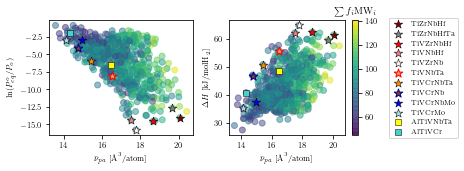

In [28]:
# v1 of plot, lnPeq vs. nu_pa, color coded by MW, with special compositions marked
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6.5,2.4))#,constrained_layout=True)

descr = aug_features_rHEA[' mean GSvolume_pa']
descr2 = np.array(aug_features_rHEA[" mean NdValence"]+\
                  aug_features_rHEA[" mean NpValence"]+\
                  aug_features_rHEA[" mean NsValence"])
descr3 = aug_features_rHEA[' mean SpaceGroupNumber']

#print(np.array(descr).reshape(-1,1),lnPeqo_rHEA_predict)
fit, r2, pred, inds = sk_linear_model(np.array(descr).reshape(-1,1),lnPeqo_rHEA_predict)
print("MAE in lnPeq of linear model with nu_pa: ", np.mean(np.abs(pred-lnPeqo_rHEA_predict)))

fit, r2, pred, inds = sk_linear_model(np.array(descr).reshape(-1,1),lnPeqo_rHEA_predict)
print("MAE in dH of linear model with nu_pa: ", np.mean(np.abs(pred-lnPeqo_rHEA_predict)))

cm = plt.cm.get_cmap('viridis')
sc = axs[0].scatter(descr,lnPeqo_rHEA_predict,c=allweights,vmin=min(allweights), vmax=max(allweights),
                   cmap=cm,linewidths=1,alpha=0.5)
sc = axs[1].scatter(descr,dH_rHEA_predict,c=allweights,vmin=min(allweights), vmax=max(allweights),
                   cmap=cm,linewidths=1,alpha=0.5)
# sc = axs[2].scatter(descr3,dS_rHEA_predict,c=allweights,vmin=min(allweights), vmax=max(allweights),
#                   cmap=cm,linewidths=1,alpha=1)

cb = plt.colorbar(sc)
cb.ax.set_title(r"$\sum f_i \textrm{MW}_i$")
axs[0].set_xlabel(r"$\bar{\nu}_{pa}\textrm{ [\AA}^3\textrm{/atom]}$")
axs[1].set_xlabel(r"$\bar{\nu}_{pa}\textrm{ [\AA}^3\textrm{/atom]}$")
#axs[2].set_xlabel(r"$\nu_{pa}\textrm{ [\AA}^3\textrm{/atom]}$")
axs[0].set_ylabel(r"$\ln (P_{eq}^o/P_o)$")
axs[1].set_ylabel(r"$\Delta H\textrm{ [kJ/molH}_{2}\textrm{]}$")
#axs[1].set_ylabel(r"$\Delta H\textrm{ [kJ (mol}_{\textrm{H}_{2}})^{-1}\textrm{]}$")
#axs[2].set_ylabel(r"$\Delta S\textrm{ [J (mol}\cdot\textrm{H}_{2}\textrm{ K})^{-1}]$")

setcombinations = [set(c) for c in allcombinations]

s1=80
s2=30

for i in range(2):
    ax = axs[i]
    if i == 0:
        yval = lnPeqo_rHEA_predict
        xval = descr
    elif i ==1 :
        yval = dH_rHEA_predict
        xval = descr
    elif i == 2 :
        yval = dS_rHEA_predict
        xval = descr3

    # Materials Gustav has already made
    thiscomplist = ["Nb","Ti","Zr","Hf"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='*',s=s1, c='maroon',linewidths=0.5)

    thiscomplist = ["Nb","Ti","Zr","Hf", "Ta"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='*',s=s1, c='gray',linewidths=0.5)

    thiscomplist = ["Nb","Ti","V","Zr","Hf"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='*',s=s1, c='red',linewidths=0.5)

    thiscomplist = ["Nb","Ti","V","Hf"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='*',s=s1, c='lightcoral',linewidths=0.5)

    thiscomplist = ["Nb","Ti","V","Zr"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='*',s=s1, c='seashell',linewidths=0.5)

    thiscomplist = ["Nb","Ti","V","Ta"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='red',marker='*',s=s1, c='sandybrown',linewidths=1)

    thiscomplist = ["Nb","Ti","V","Cr","Ta"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='*',s=s1, c='darkorange',linewidths=0.5)

    #thiscomplist = ["Nb","Ti","V","Pd"]
    #plotfcn(ax,thiscomplist,descr,yval, descr2, edgecolor='black',marker='*',s=s1, c='green',linewidths=0.5)

    thiscomplist = ["Nb","Ti","V","Cr"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='darkblue',marker='*',s=s1, c='saddlebrown',linewidths=1)

    thiscomplist = ["Nb","Ti","V","Cr","Mo"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='*',s=s1, c='blue',linewidths=0.5)

    thiscomplist = ["Ti","V","Cr","Mo"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='*',s=s1, c='lightblue',linewidths=0.5)
    
    # Suggested materials
    thiscomplist = ["Nb","Ti","V","Ta","Al"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='s',s=s2, c='yellow',linewidths=0.5)

    #thiscomplist = ["Nb","Ti","V","Zr","Mo"]
    #plotfcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='s',s=s2, c='purple',linewidths=0.5)
    #
    #thiscomplist = ["Ti","V","Zr","Al","Cr","Mo"]
    #plotfcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='s',s=s2, c='saddlebrown',linewidths=0.5)
    #
    #thiscomplist = ["Ti","V","Zr","Al","Cr"]
    #plotfcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='s',s=s2, c='plum',linewidths=0.5)
    #
    thiscomplist = ["Ti","V","Al","Cr"]
    plot_special_marker_fcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='s',s=s2, c='mediumturquoise',linewidths=0.5)
    
    #thiscomplist = ["Ti","V","Al","Cr","Mo"]
    #plotfcn(ax,thiscomplist,xval,yval, descr2, edgecolor='black',marker='s',s=s2, c='black',linewidths=0.5)
    #
    #thiscomplist = ["Ti","Al","Cr","Mo"]
    #plotfcn(ax,thiscomplist,xval,yvakl,descr2, edgecolor='black',marker='s',s=s2, c='blue',linewidths=0.5)

#     thiscomplist = ["V","Pd","Cr","Mo"]
#     plot_special_marker_fcn(ax,thiscomplist,xval,yval,descr2, edgecolor='black',marker='s',s=s2, c='red',linewidths=0.5)

#axs[1].legend(bbox_to_anchor=(1.35, 1.05), loc='upper left', prop={'size':5.5})
axs[1].legend(bbox_to_anchor=(1.35, 1.05), loc='upper left', prop={'size':7})

plt.tight_layout(pad=1)

#plt.savefig('figures/rHEA_screening.pdf')
plt.show()

# 6. Results - Model interpretability w/SHAP

## 6.1. HydPARK+ Model SHAP summary

In [29]:
# Number of features to plot
top=9

In [30]:
m = estplus_lnPeqo._finalest
fea = deepcopy(aug_features_rHEA)

explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(fea)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


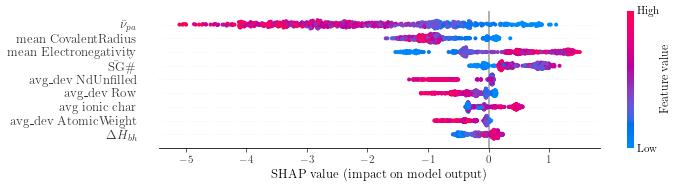

In [31]:
# fea.columns = [col.replace('_','\_') for col in fea.columns]
# lookupcols = [col.replace('_','\_') for col in colnames_by_importance]
fea.columns = [prettify_magpie_v3(col) for col in fea.columns]
#lookupcols = [prettify_magpie_v3(col) for col in colnames_by_importance]
try:
    shap.summary_plot(shap_values, fea, max_display=top, show=False, plot_size=(10,2.66667))
except Exception:
    fea = deepcopy(aug_features_rHEA)
    traceback.print_exc()
    
fea = deepcopy(aug_features_rHEA)

xlimplus = plt.xlim()
plt.tight_layout()
plt.savefig('figures/HydPARKp_FI.png',dpi=300)



In [32]:
shap.force_plot(explainer.expected_value, shap_values[2,:], fea.iloc[2,:])
#shap.force_plot(explainer.expected_value, shap_values[2,:], aug_features_exp.iloc[2,:])

## 6.2. Original Model SHAP summary

In [33]:
m = est_lnPeqo._finalest
fea = deepcopy(aug_features_rHEA)

shap.initjs()
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(fea)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [34]:
#shap.force_plot(explainer.expected_value, shap_values, fea)

In [35]:
# fea.columns = [col.replace('_','\_') for col in fea.columns]
# try:
#     shap.dependence_plot("E\_HM mu", shap_values, fea)
# except:
#     pass
# fea.columns = [col.replace('\_','_') for col in fea.columns]

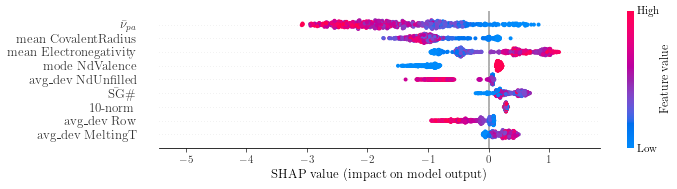

In [36]:
# can do this without computing manually
# shap_values_abs_sum = np.sum(np.abs(shap_values),axis=0)
# inds = np.argsort(shap_values_abs_sum)[::-1]
# colnames_by_importance = list(fea[fea.columns[inds]].columns)

fea.columns = [prettify_magpie_v3(col) for col in fea.columns]

try:
    shap.summary_plot(shap_values, fea, max_display=top, show=False, plot_size=(10,2.66667))
except Exception:
    fea = deepcopy(aug_features_rHEA)
    traceback.print_exc()

fea = deepcopy(aug_features_rHEA)

xlim = plt.xlim(xlimplus)
plt.tight_layout()
plt.savefig('figures/HydPARK_FI.png',dpi=300)

In [37]:
shap.force_plot(explainer.expected_value, shap_values[2,:], fea.iloc[2,:])
#shap.force_plot(explainer.expected_value, shap_values[2,:], aug_features_exp.iloc[2,:])

# 7. Final data table of all HEA predictions

In [38]:
translate = {'0.0':'IM','1.0':'SS','2.0':'SS+IM'}
phase_predictions = pd.read_csv('ml_data/rHEA_phase_data_final.csv',index_col=0)
phase_predictions['Composition'] = [pym.core.Composition(c) for c in phase_predictions['Composition_Formula']]
phase_predictions.drop(['Composition_Formula'],axis=1,inplace=True)
phase_predictions['GBTPredict']=[translate['%.1f'%s] for s in phase_predictions['GBTPredict']]
phase_predictions['AWEMLPredict']=[translate['%.1f'%s] for s in phase_predictions['AWEMLPredict']]


thermo_predictions = pd.DataFrame(allcompositions,columns=["Composition_Formula"])
thermo_predictions['Composition'] = allpymcomps
thermo_predictions['lnPeqo'] = estplus_lnPeqo._finalest.predict(aug_features_rHEA)
thermo_predictions['dH'] = estplus_dH._finalest.predict(aug_features_rHEA)
thermo_predictions['dS'] = estplus_dS._finalest.predict(aug_features_rHEA)
thermo_predictions.drop(['Composition_Formula'],axis=1,inplace=True)


final_predictions = phase_predictions.merge(thermo_predictions, left_on = 'Composition', right_on='Composition')
final_predictions['ElemSortAMU'] = ["".join([str(e) for e in sorted([el for el in c.elements if str(el) !='H'], key=lambda x: x.number)]) 
               for c in final_predictions['Composition']]
final_predictions = final_predictions.reindex(columns=['Composition','ElemSortAMU','GBTPredict','AWEMLPredict','lnPeqo','dH','dS'])

In [39]:
final_predictions

,Composition,ElemSortAMU,GBTPredict,AWEMLPredict,lnPeqo,dH,dS
0,"(Al, Cr, Ta, Zr)",AlCrZrTa,SS,SS,-8.858740,50.784286,89.296502
1,"(Al, Cr, Ta, Ti)",AlTiCrTa,SS,SS,-6.187866,45.727562,91.085855
2,"(Al, Cr, Ta, Mo)",AlCrMoTa,SS,SS,-4.858469,35.759529,83.666882
3,"(Al, Cr, Ta, V)",AlVCrTa,SS,SS,-3.988030,35.605845,87.334991
4,"(Al, Cr, Ta, Pd)",AlCrPdTa,SS,SS,-5.003804,38.829366,92.369669
...,...,...,...,...,...,...,...
667,"(Zr, Ti, Mo, V, Nb, Hf)",TiVZrNbMoHf,SS,SS,-11.443576,54.489129,90.438232
668,"(Zr, Ti, Mo, Pd, Nb, Hf)",TiZrNbMoPdHf,SS,SS,-4.501667,39.291108,102.700241
669,"(Zr, Ti, V, Pd, Nb, Hf)",TiVZrNbPdHf,SS,SS,-10.047116,48.289756,96.741730
670,"(Zr, Mo, V, Pd, Nb, Hf)",VZrNbMoPdHf,SS,SS,-3.206859,38.542743,104.507688


In [40]:
final_predictions.to_csv('ml_data/rHEA_allpredictions_final.csv')

In [41]:
# how to find data entry w/o knowing the correct atomic ordering
pd.concat([final_predictions.loc[final_predictions['Composition'] == pym.core.Composition('VCrNbMo')]],axis=0)

,Composition,ElemSortAMU,GBTPredict,AWEMLPredict,lnPeqo,dH,dS
131,"(Cr, Mo, V, Nb)",VCrNbMo,SS,SS,-2.389608,32.253535,93.251139
